# Principal Components Analysis

#### Libraries

In [2]:
## Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # makes figs nicer!

## Goals of this lecture
 
- **Dimensionality reduction**: what's it good for?
- Conceptual introduction to **principal components analysis**.
- Finding the components with **linear algebra**.
- Walking through PCA in `sklearn`.

## What is dimensionality reduction?

> **Dimensionality reduction** refers to the transformation of data from some higher-dimensional space to some lower-dimensional space.

- E.g., transform a $100$-dimensional space to a $10$-dimensional space.
- Very important for **exploratory data analysis**.

### What's it good for?

- In CSS, many datasets are very *high-dimensional*.
  - **Social network data**: all your posts, friends, etc.
  - **Consumer data**: all your purchases, all *possible* purchases...
  - **Survey data**: many surveys contain hundreds or thousands of questions (e.g., [World Values Survey](https://www.worldvaluessurvey.org/wvs.jsp)).
  - **Text data**: the *count* of every possible word in each document, etc.
- In some cases, we have more **parameters** than **data points** ($p > n$)!

Dimensionality reduction **simplifies** the problem for us.


### The "curse" of dimensionality

Having lots of features has its downsides.

- **Hard to visualize**: very difficult to visualize more than $2$ or $3$ features at once.
- **Hard to interpret model coefficients**: as $p$ increases, can be harder to interpret fit coefficients. 
- **Potential for overfitting**: $p>n$ is a recipe for overfitting! 
- **Less useful distance metrics**: in sufficiently high-dimensional spaces, the *contrast* between distances sometimes decreases.
   - This is particularly true for **sparse** high-dimensional data.


### A motivating example (1)

- Suppose you have a bunch of wines, and a bunch of *features* to describe those wines with.
   - `color`, `alcohol`, `acidity`, `sugar`, `age`, etc.
- Is there a *reduced* set of features you could use to adequately **summarize** those wines?

<img src="img/wines.jpeg" width="200" alt="Different wines">


#### Simplify, simplify

- Presumably, some features are **correlated** (e.g., `color` and `alcohol`?).
- But our goal is *not* to throw out redundant features (e.g., `alcohol`).
- Rather, we want to create **new features** that combine the original features in helpful ways.
  - E.g., maybe the *average* of `color` and `alcohol` (or the *difference*).
- PCA aims to find *linear combinations* of our original features that:
   - *Explain lots of variance* in the original feature-space.
   - Allow us to *reconstruct* the original feature-space as well as possible.



### A motivating example (2)

- Suppose you want to predict the GDP of the USA in the future.
- You have *tons of features*.
   - Indicators of economic activity (`unemployment_rate`, `labor_participation_rate`, etc.)
   - US Census data (industry-level activity, etc.)
   - Stock price data (e.g., rolling average for `NASDAQ`, etc.)
   - And much more.
- Maybe we'd do a better job predicting (and understanding) GDP if we created **composite variables**.


#### Simplify, simplify

- One approach would be to fit a Lasso regression model predicting `GDP`.
    - This will create a **sparse** model, i.e., result in **feature elimination**.
    - But then we learn nothing from those features!
- There's a good chance many of those features are **correlated**.
- PCA allows us to **extract** (or **create**) new features that account for the most variance in our original feature space.

### What do we want?

- We've already seen techniques like **Lasso regularization**, which can *sparsify* our regression models.
   - But this requires supervised learning——and also tosses away lots of features.
- Ideally, we'd have an approach that would **simplify** our data without **losing too much information**.
   - E.g., don't just *toss out* $90$ of $100$ features.
   - Instead, maybe we can *combine* those $100$ features in strategic ways.

> **Problem statement**: Given $p$ features, is there some way to *combine* them using $<p$ features (or "components") that *loses as little information* as possible?

## Conceptual introduction to PCA

> **Principal components analysis (PCA)** is a dimensionality reduction technique that involves finding the *components* that explain the most amount of variance in your original dataset.

- Given $p$ features, we want $<p$ components to summarize those features.
- Ideally, we'd like to be able to **reconstruct** our original dataset as well as possible using those components.
    - You can think of this as a **compression** technique.

### Benefits (and downsides) of PCA

- Allows us to represent high-dimensional data in lower-dimensional space *without eliminating features altogether*.
- Components are *ordered* in terms of how much variance they explain.
- These new components are also **independent** of each other.
    - Useful if you want to use them as predictors in a linear model!

One downside is those new features are less **interpretable**, since each one represents a *combination* of the original features.

### Explaining the *most variance*

Given two variables $X_1$ and $X_2$, PCA aims to project all points onto a line that:

- **Maximizes variance** along that line (the spread of red dots).
- **Minimizes the reconstruction** error (the size of the red lines).

The best of these lines is called our first *principal component*. Let's talk about how to actually find this!

<img src="img/variance_animation.gif" width="600" alt="Finding the best line">

[[Source](https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues)]

#### Principal components as linear combinations of features

Given some set of features $X_1, ..., X_p$, our first principal component $Z_1$ can be described by the *normalized* linear combination of features:

$$Z_1 = \phi_{11}X_1 + ... + \phi_{p1}X_p$$

- By *normalized*, we mean $\sum_{j=1}^p\phi_{j1}^2=1$.
   - This is to make sure they don't take on arbitrarily large values.
- Each $\phi_{j1}$ is a **loading** for that first principal component.

How do we find the loadings?

#### Optimizing the loadings $\phi$

- Given an original feature space $X$ of dimensions $(n, p)$...
- ...we look for sample features of the form:

$$z_{i1} = \phi_{i1}X_{i1} + ... + \phi_{ip}X_{ip}$$

- Such that our optimal values of $\phi$ **maximize the squared variance** of our new feature (component). 

$$\frac{1}{n}\sum_{i=1}^nz_{i1}^2$$

- This is a *mathematical* formulation of what we saw earlier——maximizing the variance along the linear combination of features.

#### Check-in

What else does this optimization problem remind you of?

I.e., we want to find loadings:

$$z_{i1} = \phi_{i1}X_{i1} + ... + \phi_{ip}X_{ip}$$

Such that we maximize:

$$\frac{1}{n}\sum_{i=1}^nz_{i1}^2$$

In [4]:
### Your code here

#### PCA loadings vs. regression coefficients

- In **linear regression**, we aim to find coefficients $\beta_1, ..., \beta_p$ that *minimize* the sum of squared prediction errors ($RSS$).
- Here, we want to *maximize* the variance of the resulting distribution of values in our sample feature.

$$\frac{1}{n}\sum_{i=1}^nz_{i1}^2$$

#### What about other principal components?

- Above, we discussed finding the *first* principal component.
- Finding additional principal components (e.g., $Z_2$) use the same strategy.
- Key difference: for any given component $Z_i$, we find the loadings that:
    - Maximize the squared variance (as before).
    - Are **orthogogonal** (perpendicular) to previous components!
- This second constraint is why our principal components are **independent**.



#### Check-in

Based on this formulation, what might you expect about the *amount of variance* by each successive principal component?


In [5]:
### Your answer here

#### Each component explains less variance

- Our first principal component will always be the "best".
- Additional principal components will explain less variance.
- Sometimes this drop-off is quite sharp, and sometimes it's less gradual.
  - This can be visualized using a **scree plot**, which depicts the $\%$ of variance explained with each successive component.

<img src="img/scree.png" width="300" alt="scree plot">


### Interim summary: PCA

- PCA is a **dimensionality reduction** technique.
- Given features $X$ of dimensions $(n, p)$, we want to create a *smaller* matrix of dimensions $(n, z)$, where $z < p$.
- Each principal component $Z_i$ is a **linear combination** of our original features.
  - This linear combination is determined by "loadings" $\phi$ for each original feature.
- Our goal is to find loadings that **maximize the variance** of that new feature.
- Each successive principal component must also be **orthogonal to** previous components.

> Okay, but how do we actually *find* those loadings?

## Finding loadings: the messy details

- Before, we discussed the **loadings** $\phi$:

$$Z_1 = \phi_{11}X_1 + ... + \phi_{p1}X_p$$

- Explaining how we *find* the optimal loadings requires some linear algebra.
- Note: This is *not* a linear algebra class, so I will not test you on the details here.
  - I'm only reviewing them briefly in case you want to dive into the details more.

### A high-level algorithm

At a [high-level](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c), we'll need to:

1. **Standardize** those features $X$; call the new matrix $Z$.
2. Calculate the **covariance matrix** for $Z$.
3. Using the covariance matrix, calculate the **eigenvectors** and **eigenvalues**.
    - This is called an *eigen decomposition*.
4. Sort the eigenvalues $\lambda_1, ..., \lambda_p$ and sort them from largest to smallest.
    - Sort the eigenvectors $P$ accordingly; call this sorted matrix $P*$.
5. Now, calculate $Z* = ZP*$.

This new matrix, $Z*$, is a version of $X$, where each observation is now a **combination** of the original features.

Let's walk through this step-by-step!

#### A working example

- Let's assume we have only two features, $X_1$ and $X_2$.
- We've designed these features to be correlated.

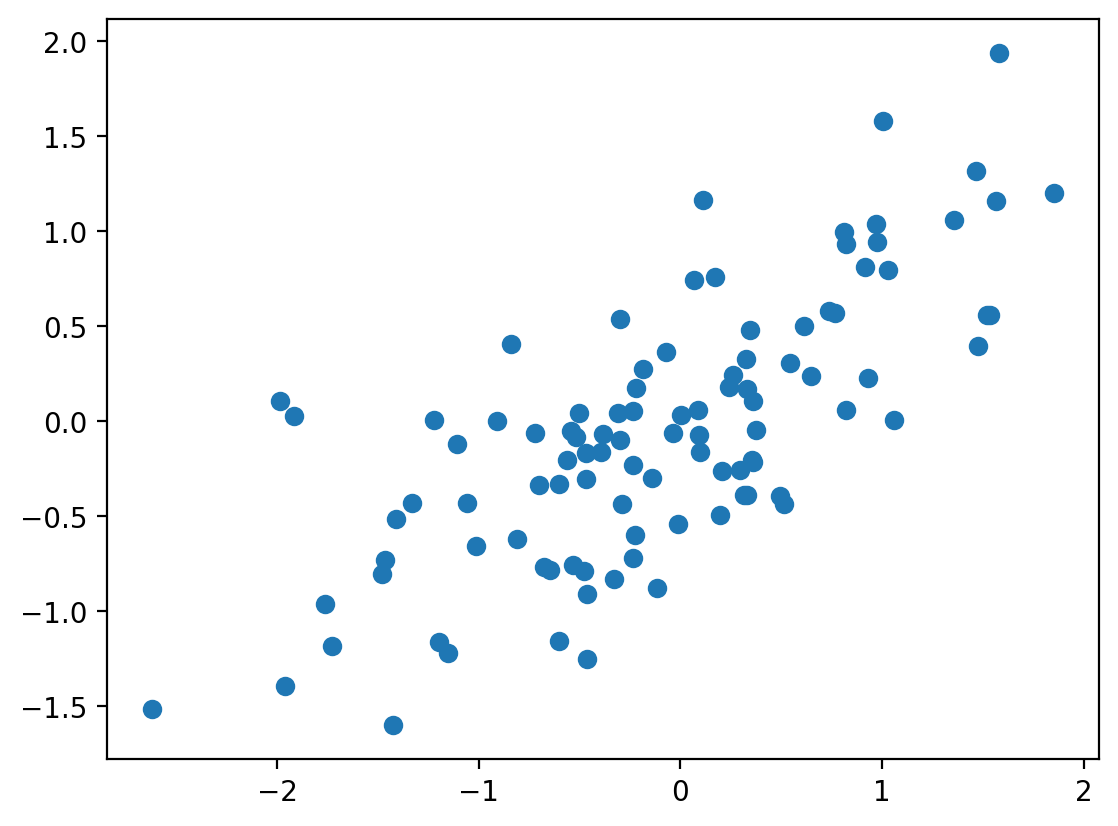

In [6]:
np.random.seed(42)
x1 = np.random.normal(loc = 0, scale = 1, size = 100)
x2 = x1 * 0.63 + np.random.normal(loc = 0, scale = .5, size = 100)

plt.scatter(x1, x2)

#### Step 1: Center our variables

- As a first step, we'd **center** these variables (and possibly **standardize** them).
- We'll call this new matrix $Z$.

In [7]:
# Combine x1 and x2 into a single 2D array (matrix)
X = np.column_stack((x1, x2))

# Standardize
mean_X = np.mean(X, axis=0) 
std_X = np.std(X, axis=0)

# For now, just center
Z = (X - np.mean(X, axis=0)) 
Z.shape

(100, 2)

#### Step 2: Covariance matrix

> A **covariance matrix** represents the variance of each of our features, as well as the shared variance.

For two features, we'd have a $2x2$ matrix, such as below.

- `0.82` is the variance of $X_1$.
- `0.48` is the variance of $X_2$.
- `0.46` is the co-variance between $X_1$ and $X_2$.

In [8]:
cov = np.cov(Z, rowvar=False) 
cov

array([[0.82476989, 0.46052794],
       [0.46052794, 0.48028515]])

#### Step 3: Eigen decomposition

This is by far the hardest step to understand!

- In `numpy`, we can simply use `np.linalg.eig` on our covariance matrix.
- In just a moment, I'll explain what's actually happening here.



In [9]:
# Calculate eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(cov)

In [10]:
print(eigenvalues)

[1.14421179 0.16084326]


In [11]:
prop_var = eigenvalues / sum(eigenvalues)
prop_var

array([0.87675366, 0.12324634])

In [10]:
print(eigenvectors)

[[ 0.82167844 -0.56995135]
 [ 0.56995135  0.82167844]]


#### So what are eigenvalues and eigenvectors?

- Given some square matrix $A$ (e.g., **covariance matrix**), its eigenvector $v$ and eigenvalue $\lambda$ satisfies:

$$Av=λv$$

- Which can be rearranged to:

$$(A−λI)v=0$$

- Where $I$ is simply the **identity matrix**.
- Solving for $\lambda$ and $v$ is [beyond the scope of this class](https://en.wikipedia.org/wiki/Eigendecomposition_of_a_matrix).

#### Step 4: sort the eigenvalues

- Now, we make sure our **eigenvalues** are sorted by their size.
- The largest eigenvalue should be first.
- We also sort the **eigenvectors** accordingly to align them with the eigenvalues.


In [12]:
# Sort the eigenvalues and eigenvectors
sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]

# Print sorted eigenvalues and eigenvectors
print("Sorted Eigenvalues:")
print(sorted_eigenvalues)
print("Sorted Eigenvectors:")
print(sorted_eigenvectors)

Sorted Eigenvalues:
[1.14421179 0.16084326]
Sorted Eigenvectors:
[[ 0.82167844 -0.56995135]
 [ 0.56995135  0.82167844]]


#### Step 4b: Comparing eigenvalues

- Recall that different **components** will explain different amounts of variance.
- In this case, we have only two components, but we can still compare them.

Text(0.5, 0, 'PC')

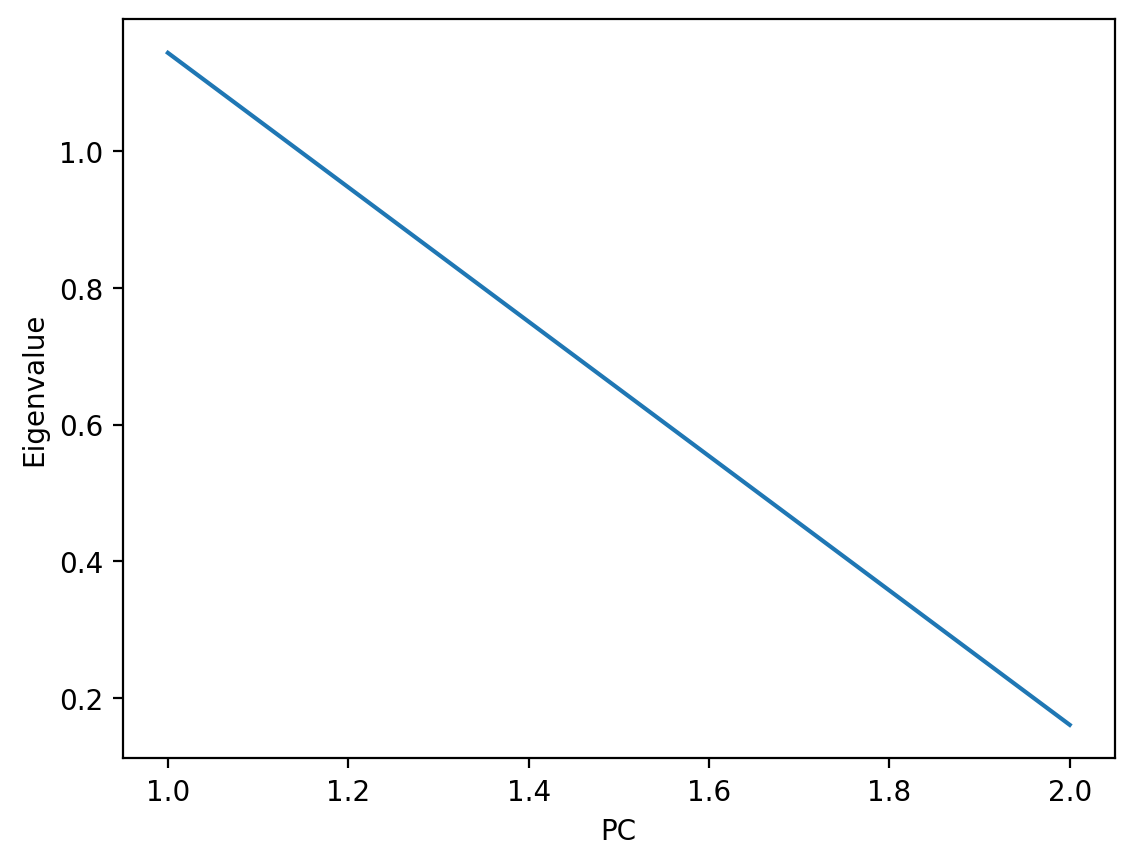

In [13]:
### Raw eigenvalues
sns.lineplot(x = [1, 2], y = eigenvalues)
plt.ylabel("Eigenvalue")
plt.xlabel("PC")

/Users/seantrott/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/seantrott/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0, 'PC')

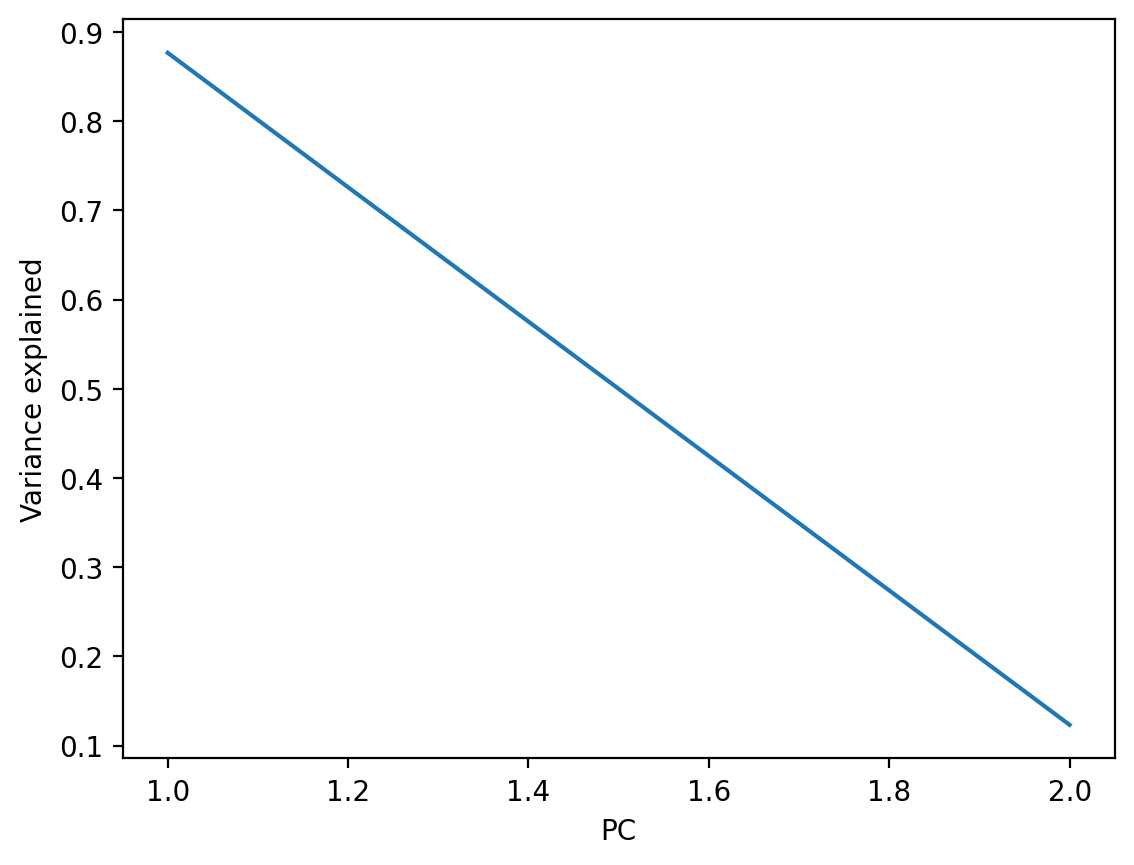

In [13]:
### Raw eigenvalues
var_explained = eigenvalues / eigenvalues.sum()
sns.lineplot(x = [1, 2], y = var_explained)
plt.ylabel("Variance explained")
plt.xlabel("PC")

#### Step 5: Dimensionality reduction

- Now, we multiply our scaled matrix $Z$ by our sorted eigenvectors.
- Each column of this new matrix, $Z*$, will represent our new **principal component features**.

In [19]:
Z_star = np.dot(Z, eigenvectors)
Z_star.shape
(Z_star == Z).mean() != 1

True

### Interim summary

- PCA is a **dimensionality reduction** technique.
- Each of our new features represents a *linear combination* of the original features.
- The process for obtaining those new features involves **eigendecomposition** of the original feature space.

Now let's look at how PCA works in `sklearn`!

## PCA in `sklearn`

The `sklearn` library has a very useful [`PCA` class](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) that can be used for dimensionality reduction.

In [15]:
from sklearn.decomposition import PCA

### Using `PCA`

- Key parameter is `n_components`: number of components to keep.
- To use, call `pca.fit_transform(X)`.
    - This will yield a **new matrix** representing a reduced version of `X`.

In [16]:
### A pca instance with 5 target components
pca = PCA(n_components=5)

#### A sample dataset

- The **Pokemon dataset** has a number of features for each Pokemon.
- Let's select $7$ of those features and see if we can create a simpler, reduced-dimensionality feature space.

In [17]:
df_pokemon = pd.read_csv("data/pca/pokemon.csv")
df_pokemon.shape

(800, 13)

In [18]:
### Features to target
features = ['HP', 'Attack', 'Defense', 'Speed',
            'Sp. Atk', 'Sp. Def', 'Legendary']
len(features)

7

#### Using `pca.fit_transform`

- Now, we can call `pca.fit_transform`.
   - Note this will automatically *center* our data $X$.
- This will return a matrix of shape `(n, n_components)`. 

In [19]:
### Get the features
X = df_pokemon[features]
X.shape

(800, 7)

In [20]:
### call fit_transform
X_reduced = pca.fit_transform(X)
X_reduced.shape

(800, 5)

#### Investigating our `pca` object

- Recall that different **components** will explain different amounts of variance.
- The `pca` object indicates how much variance was explained by each component.

In [21]:
### Original eigenvalues
pca.explained_variance_

array([2474.28371058, 1006.54428359,  729.14631729,  526.21340632,
        396.03572189])

In [22]:
### Normalized eigenvalues (sums to 1)
pca.explained_variance_ratio_

array([0.46095845, 0.18751895, 0.13583978, 0.09803343, 0.07378136])

#### A *scree plot* 

- A **scree plot** visualizes the amount or proportion of variance explained by each principal component.
- This is helpful for figuring out which (and how many) components we want to keep, ideally.

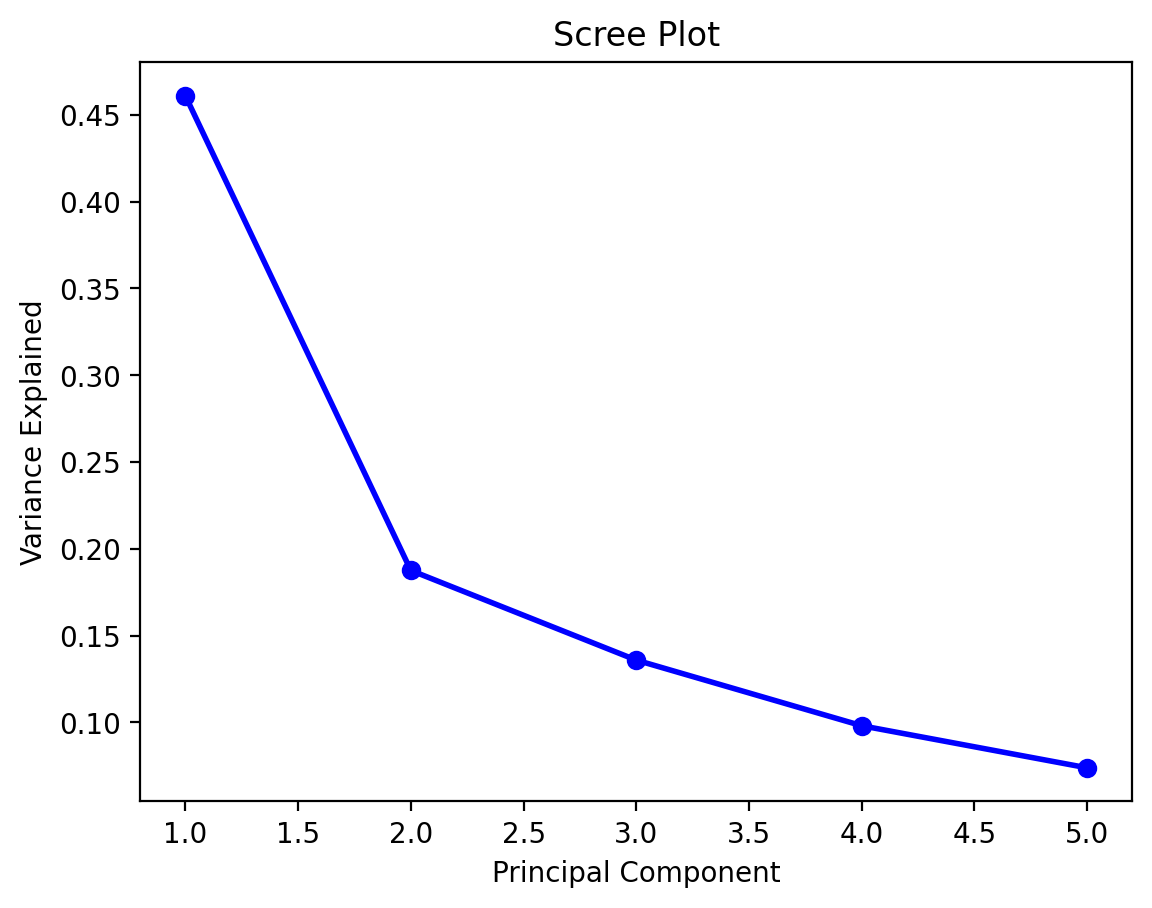

In [23]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

#### Inspecting the components

- Recall that each component is a **linear combination** of our features.
- `pca.components_` is a matrix showing how each **component** maps onto each **feature**.
- This is useful for figuring out what each component reflects.


In [24]:
### 5 components mapping onto 7 features
pca.components_.shape

(5, 7)

In [25]:
### Our first PC
pca.components_[0]

array([0.30080646, 0.49288934, 0.38063209, 0.32726206, 0.50897957,
       0.39436838, 0.00277673])

#### Mapping components to features

- To make this easier to track, let's create a `DataFrame`.
- Each *row* will represent one of our original features.
- Each *column* will represent the loadings for a given principal component.

In [26]:
df_loadings = pd.DataFrame(pca.components_.T, 
                           columns=[f'PC{i+1}' for i in range(pca.n_components)])
df_loadings['Feature'] = features
df_loadings.head(2)

,PC1,PC2,PC3,PC4,PC5,Feature
0,0.300806,0.042212,-0.058984,0.801593,0.387167,HP
1,0.492889,0.076547,-0.730432,0.027363,-0.193247,Attack


#### Visualizing the loadings (pt. 1)

- Now, we can visualize how different components load onto different features.

<Axes: xlabel='Feature', ylabel='PC1'>

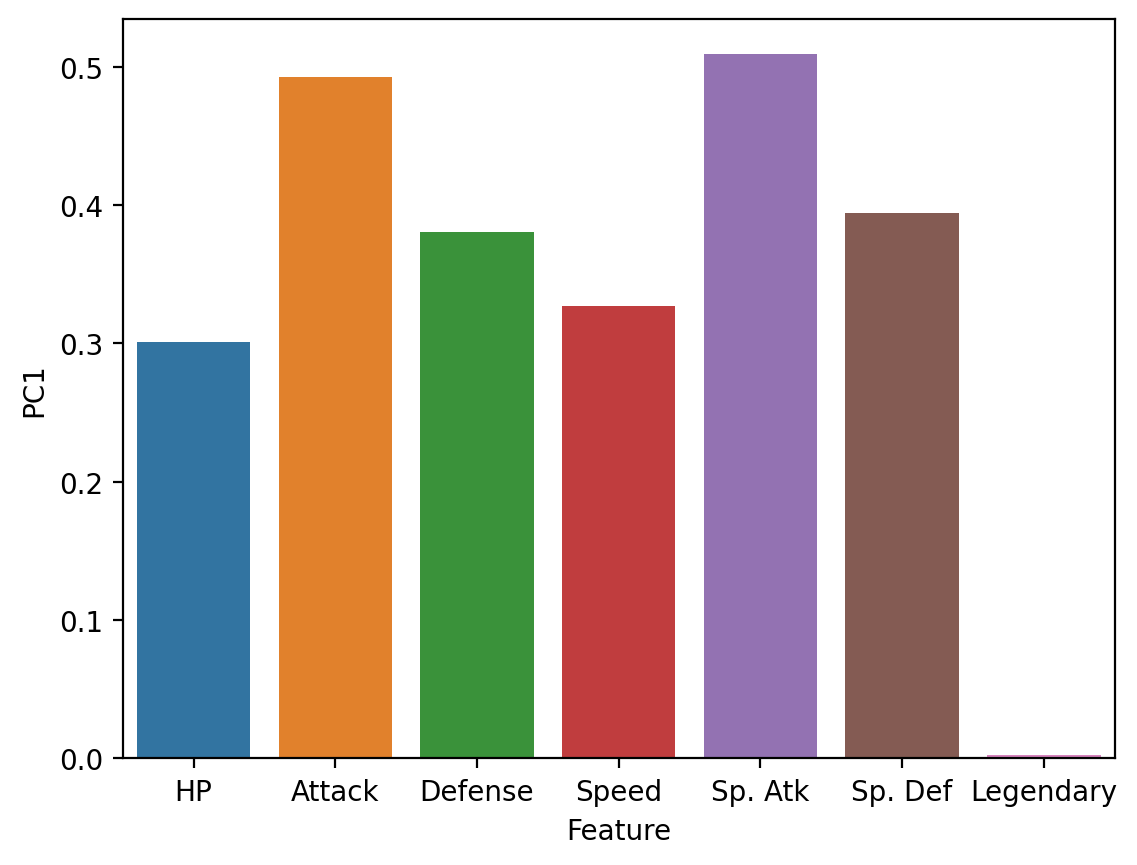

In [27]:
sns.barplot(data = df_loadings,
            x = "Feature",
            y = "PC1")

#### Visualizing the loadings (pt. 2)

- We could also visualize this with a *heatmap*.
- PC1 seems like it's just *"good at everything"* (positive loadings for everything).
- PC2 loads onto *"good at defense, but slow and weak"* (positive loadings for defense, negative for speed and special attack)..

In [30]:
loadings_with_index = pd.DataFrame(pca.components_.T, 
                           index = features,
                           columns=[f'PC{i+1}' for i in range(pca.n_components)])

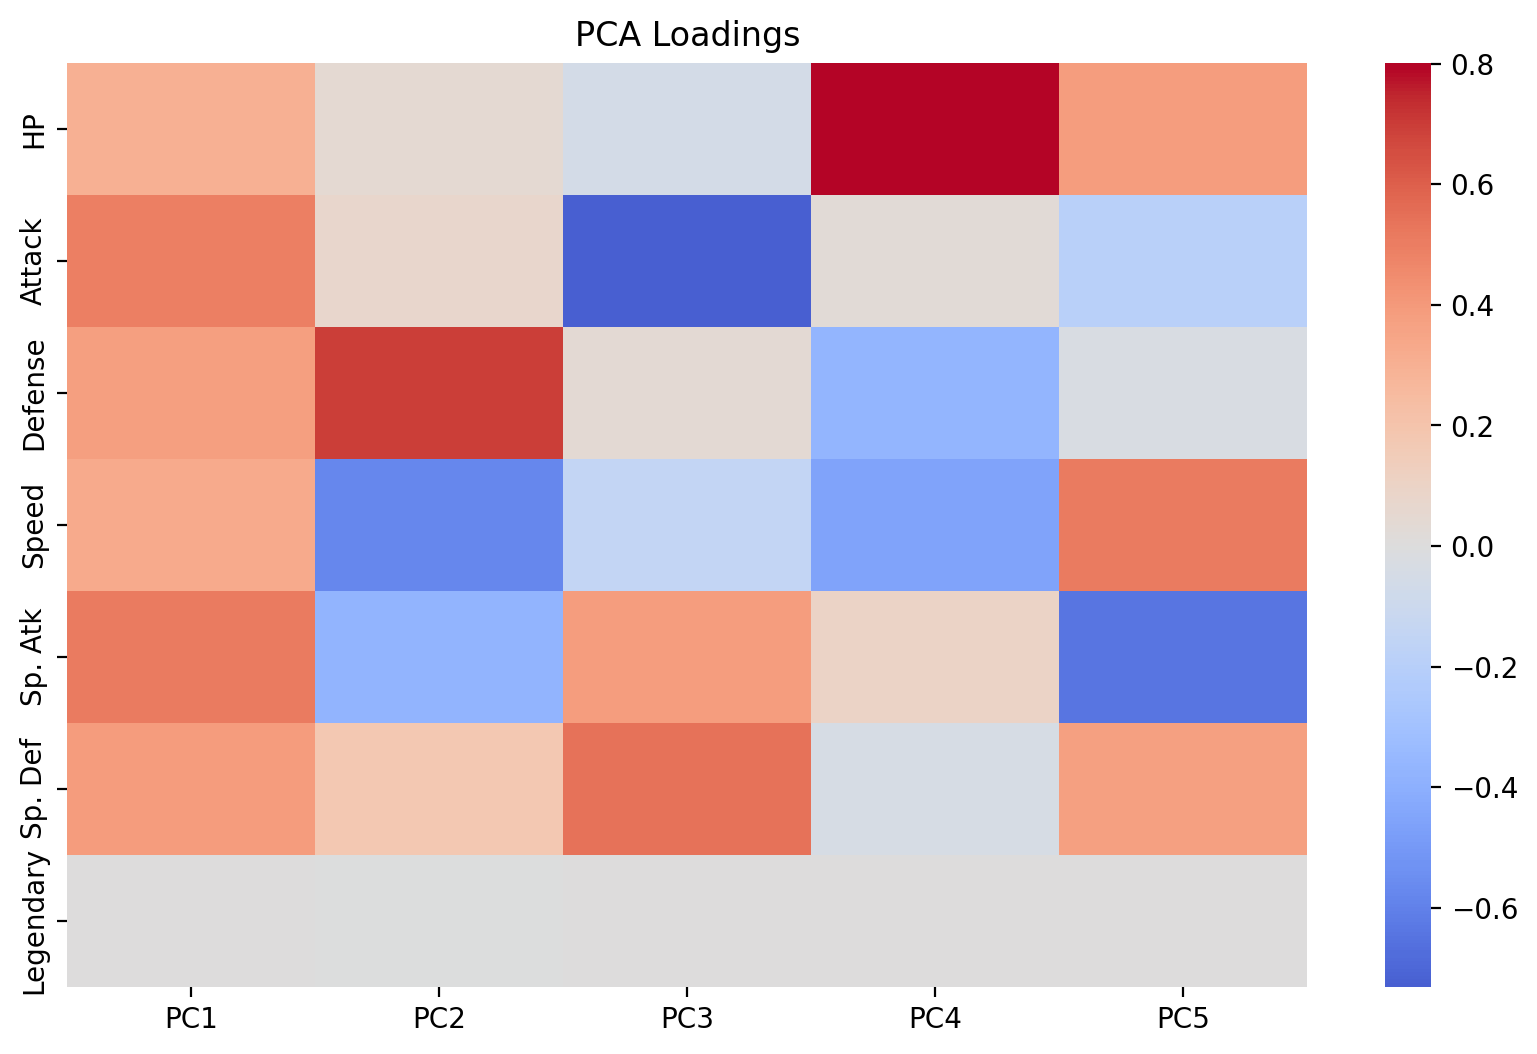

In [31]:
# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(loadings_with_index, annot=False, cmap='coolwarm', center=0)
plt.title('PCA Loadings')
plt.show()

#### Visualizing the principal components directly

Here, we create a `scatterplot` comparing our first two principal components.

Text(0.5, 0, 'PC 2')

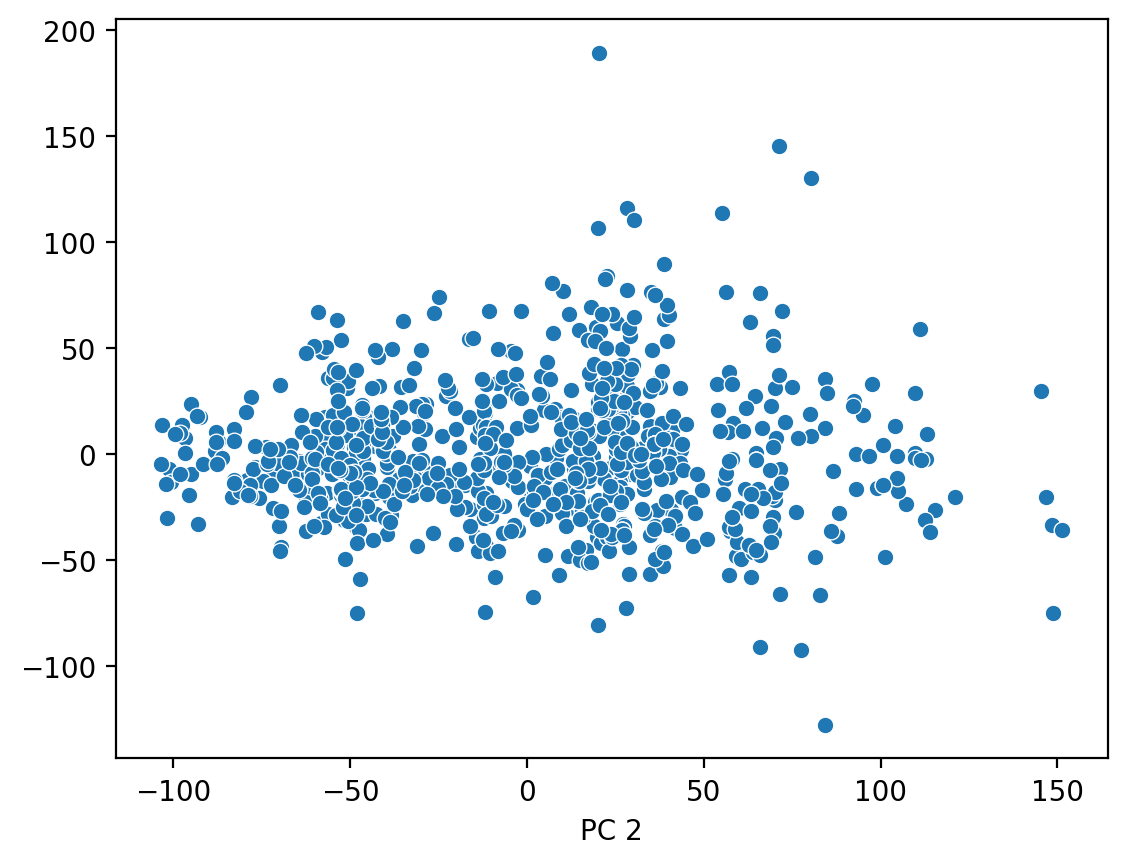

In [140]:
sns.scatterplot(x = X_reduced[:,0],
                y = X_reduced[:,1])
plt.xlabel("PC 1")
plt.xlabel("PC 2")

## Lecture wrap-up

- PCA is a widely used method for **dimensionality reduction**.
- This lecture covered the *conceptual background* of how PCA works, and a little of the details.
- There are many other dimensionality reduction techniques.
    - Multi-dimensional scaling
    - UMAP
    - Auto-encoders
- In each case, the goal is to identify some **lower-dimensional space** with which to represent your original features, with as little information loss as possible.